In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Fire Detection CNN
In this notebook, we will build tensorflow models trained on image datasets. For the image data we have collected satellite images from Planet Labs.

And we will be be training the following models

* Baseline CNN Model
* Inception V4
* EfficientNet


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Collection
We've collected all the data and split them into train, test and validation using 70,15,15 percentages and kept them under folders of fire and nofire for the positive and negative examples of images having fire and no fire. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_dir = os.path.join(os.path.dirname('/content/gdrive/My Drive/'), 'satellite_images')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
print(train_dir)
train_fire_dir = os.path.join(train_dir, 'fire')  # directory with fire pictures
print(train_fire_dir)
train_nofire_dir = os.path.join(train_dir, 'nofire')  # directory with no-fire pictures
validation_fire_dir = os.path.join(validation_dir, 'fire')  # directory with ofire pictures
validation_nofire_dir = os.path.join(validation_dir, 'nofire')  # directory with no-fire pictures
test_fire_dir = os.path.join(test_dir, 'fire')
test_nofire_dir = os.path.join(test_dir, 'nofire')
print(train_nofire_dir)

/content/gdrive/My Drive/satellite_images/train
/content/gdrive/My Drive/satellite_images/train/fire
/content/gdrive/My Drive/satellite_images/train/nofire


In [ ]:
num_fire_tr = len(os.listdir(train_fire_dir))
num_nofire_tr = len(os.listdir(train_nofire_dir))

num_fire_val = len(os.listdir(validation_fire_dir))
num_nofire_val = len(os.listdir(validation_nofire_dir))
num_fire_test = len(os.listdir(test_fire_dir))
num_nofire_test = len(os.listdir(test_nofire_dir))

total_train = num_fire_tr + num_nofire_tr
total_val = num_fire_val + num_nofire_val
total_test = num_fire_test + num_nofire_test

# Data Statistics
In this section we will show basic data stats and some sample training set images. 

In [ ]:
print('total training fire images:', num_fire_tr)
print('total training nofire images:', num_nofire_tr)

print('total validation fire images:', num_fire_val)
print('total validation nofire images:', num_nofire_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total Test Images:", total_test)

total training fire images: 72
total training nofire images: 59
total validation fire images: 19
total validation nofire images: 24
--
Total training images: 131
Total validation images: 43
Total Test Images: 61


In [ ]:
BATCH_SIZE = 100 # Number of training examples to process before updating our models variables
IMG_SHAPE  = 100  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 131 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 42 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 60 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

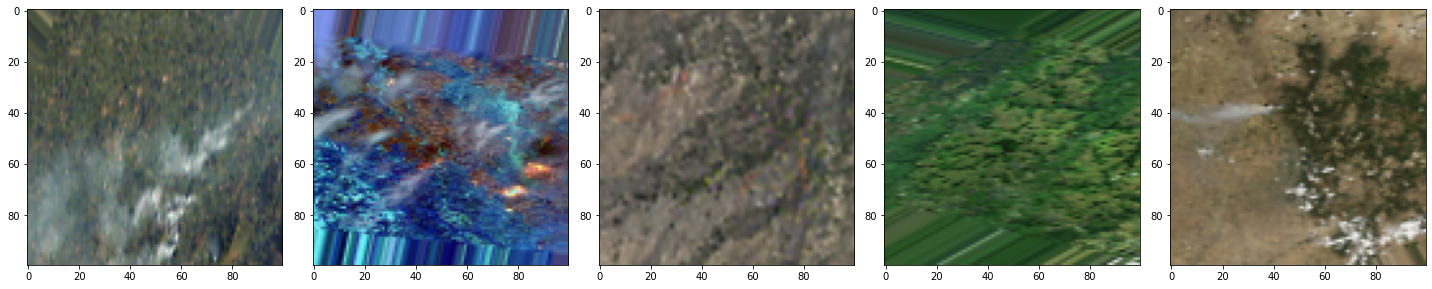

In [ ]:
plotImages(sample_training_images[10:20])  

# Baseline CNN
For this model we will be training a CNN with the following architecture
* 1st Convolutional layer with 32 neurons 
* 2nd Convolutional layer with 64 neurons 
* 3rd Convolutional layer with 128 neurons 
* 4th Convolutional layer with 128 neurons
* 5th Convolutional layer with 128 neurons

We use MaxPooling2D layers to connect all the 5 layers. And then we will follow that with 3 Dense layers of 256, 512 and 2 neurons. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
EPOCHS = 50
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    verbose=1
)

Epoch 1/50
2/2 [==============================] - 15s 13s/step - loss: 0.6912 - accuracy: 0.5815 - val_loss: 0.7082 - val_accuracy: 0.4286
Epoch 2/50
2/2 [==============================] - 11s 5s/step - loss: 0.6848 - accuracy: 0.5464 - val_loss: 0.7213 - val_accuracy: 0.4286
Epoch 3/50
2/2 [==============================] - 11s 5s/step - loss: 0.6755 - accuracy: 0.5531 - val_loss: 0.6806 - val_accuracy: 0.4286
Epoch 4/50
2/2 [==============================] - 11s 9s/step - loss: 0.6688 - accuracy: 0.5486 - val_loss: 0.6602 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 11s 9s/step - loss: 0.6452 - accuracy: 0.5866 - val_loss: 0.6579 - val_accuracy: 0.4524
Epoch 6/50
2/2 [==============================] - 11s 9s/step - loss: 0.6452 - accuracy: 0.6453 - val_loss: 0.6388 - val_accuracy: 0.9286
Epoch 7/50
2/2 [==============================] - 11s 6s/step - loss: 0.6126 - accuracy: 0.8314 - val_loss: 0.6526 - val_accuracy: 0.5952
Epoch 8/50
2/2 [=================

# Model Evaluation
In this section, we will show the accuracy and loss of the model on training and validation sets. 

In [ ]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['accuracy']
validation_acc = hist_dict['val_accuracy']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

In [ ]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

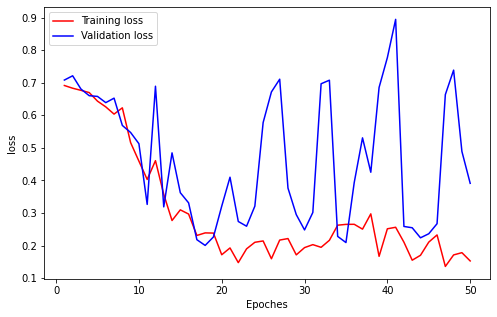

In [ ]:
plot_func('loss')

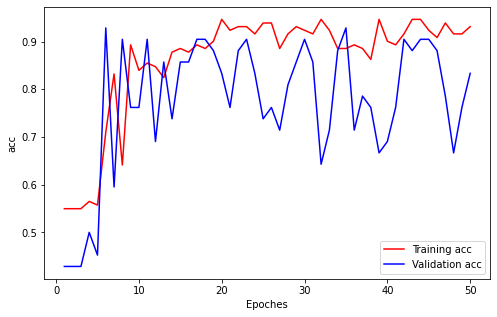

In [ ]:
plot_func('acc')

In [ ]:
model.save('fire_nofire.h5')

# Model Testing
Now we've a pretty good model, lets try it on a sample fire image and see what it predicts. 

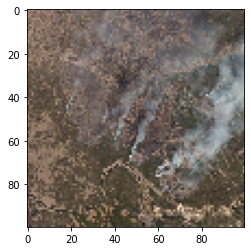

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_image =image.load_img('/content/gdrive/My Drive/satellite_images/test/fire/maple-fire-20160821-full.jpg', target_size =(100,100))
imgplot = plt.imshow(test_image)


In [ ]:
test_image =image.img_to_array(test_image)
test_image =np.expand_dims(test_image, axis =0)
result = model.predict(test_image)
if result[0][0] >= 0.5:
    prediction = 'fire'
else:
    prediction = 'No fire'
print(prediction)

fire


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_data_gen)
print("test loss, test acc:", results)


Evaluate on test data
1/1 [==============================] - 5s 5s/step - loss: 0.7587 - accuracy: 0.8500
test loss, test acc: [0.7586926817893982, 0.8500000238418579]


# Evaluation Summary
We've created a pretty good CNN model, here is the performance characteristics

* Accuarcy on Training Set = 84%
* Accuracy on Test Set = 77%
